In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Lambda, LSTM, RepeatVector
from keras.models import Model,Sequential
from keras import backend as K
from keras import metrics
from scipy.stats import norm
import pandas as pd
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

# Read Data Set

In [2]:
df = pd.read_csv("data/EEG_Eye_State.arff",comment="@",header = None)

+ Extract the label

In [3]:
y = df[df.columns[-1]]
del df[df.columns[-1]]

+ filter outliers

In [4]:
highest_quantile = np.percentile(df,99,axis=0)
df[df > highest_quantile] = np.nan
df = df.fillna(df.quantile(0.99))

In [5]:
lowest_quantile = np.percentile(df,1,axis=0)
df[df < lowest_quantile] = np.nan
df = df.fillna(df.quantile(0.01))

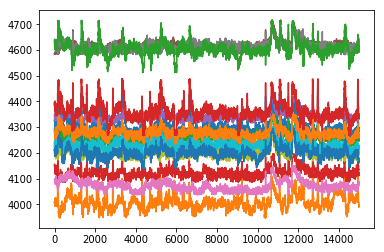

In [6]:
_ = plt.plot(df)

+ Normalize the dataset between 0 and 1

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

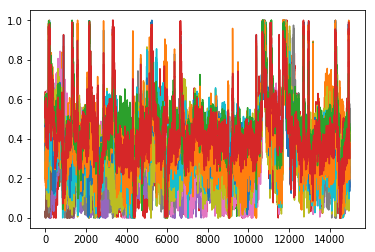

In [8]:
_ = plt.plot(df)

+ Split into train and test sets

In [11]:
train_size_proportion = 0.67
train_size = int(len(df) * train_size_proportion)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]

+ Create the dataset in a "prediction mode" s.t. X=t and Y=t+1

In [129]:
def create_dataset(dataset, look_back=1, dimension = range(14)):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), dimension]
        dataX.append(a)
        dataY.append(dataset[i + look_back, dimension])
    return np.array(dataX), np.array(dataY)

In [130]:
look_back = 3
dimensions = range(14)
trainX, trainY = create_dataset(train, look_back,dimensions)
testX, testY = create_dataset(test, look_back,dimensions)
if len(trainX.shape) < 3:
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print trainX.shape, trainY.shape

(10032, 3, 14) (10032, 14)


# LSTM not statefull

In [72]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back,len(dimensions))))
model.add(Dense(len(dimensions)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX,
          trainY,
          epochs=2,
          batch_size=1,
          verbose=2)

Epoch 1/2
79s - loss: 0.0077
Epoch 2/2
77s - loss: 0.0051


### Predict

In [135]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

+ Invert transformation for the  predictions

In [136]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY_original = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY_original = scaler.inverse_transform(testY)

+ Compute mean square error

In [137]:
train_score = mean_squared_error(trainY_original.T,
                                trainPredict.T,
                                multioutput = 'raw_values')
train_score = np.sqrt(train_score.sum()) * 1./train_score.shape[0]
print('Train Score: %.2f RMSE' % (train_score))
test_score = mean_squared_error(testY_original.T,
                                testPredict.T,
                                multioutput = 'raw_values')
test_score = np.sqrt(test_score.sum()) * 1./test_score.shape[0]
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.09 RMSE
Test Score: 0.18 RMSE


### Plot

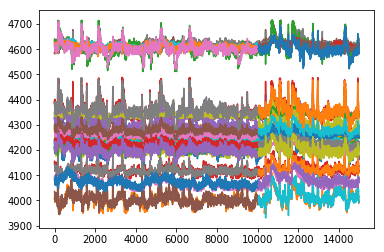

In [138]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Statefull LSTM
Needs to hardcode the batch size and reset the states at the end of each epoch

In [155]:
batch_size = 1
model_stf = Sequential()
model_stf.add(LSTM(4, batch_input_shape=(batch_size,look_back,len(dimensions)),stateful=True))
model_stf.add(Dense(len(dimensions)))
model_stf.compile(loss='mean_squared_error', optimizer='adam')
for i in range(2):
    model_stf.fit(trainX,
                  trainY,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=2,
                  shuffle=False)
    model_stf.reset_states()

Epoch 1/1
69s - loss: 0.0071
Epoch 1/1
68s - loss: 0.0033


### Predict

In [160]:
trainPredict_stf = model_stf.predict(trainX,batch_size=batch_size)
model_stf.reset_states()
testPredict_stf = model_stf.predict(testX,batch_size=batch_size)

+ Invert transformation for the predictions

In [161]:
trainPredict_stf = scaler.inverse_transform(trainPredict_stf)
trainY_original_stf = scaler.inverse_transform(trainY)
testPredict_stf = scaler.inverse_transform(testPredict_stf)
testY_original_stf = scaler.inverse_transform(testY)

+ Compute mean square error

In [163]:
train_score = mean_squared_error(trainY_original_stf.T,
                                trainPredict_stf.T,
                                multioutput = 'raw_values')
train_score = np.sqrt(train_score.sum()) * 1./train_score.shape[0]
print('Train Score: %.2f RMSE' % (train_score))
test_score = mean_squared_error(testY_original_stf.T,
                                testPredict_stf.T,
                                multioutput = 'raw_values')
test_score = np.sqrt(test_score.sum()) * 1./test_score.shape[0]
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.15 RMSE
Test Score: 0.26 RMSE


### Plot

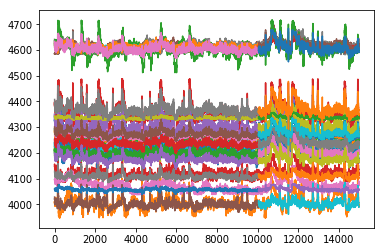

In [166]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_stf)+look_back, :] = trainPredict_stf
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_stf)+(look_back*2)+1:len(df)-1, :] = testPredict_stf
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Multilayered LSTM

In [214]:
model_m_stf = Sequential()
model_m_stf.add(LSTM(4, batch_input_shape=(batch_size, look_back, len(dimensions)), stateful=True, return_sequences=True))
model_m_stf.add(LSTM(4, batch_input_shape=(batch_size, look_back, len(dimensions)), stateful=True))
model_m_stf.add(Dense(len(dimensions)))
model_m_stf.compile(loss='mean_squared_error', optimizer='adam')
for i in range(2):
    model_m_stf.fit(trainX,
                    trainY,
                    epochs=1,
                    batch_size=batch_size,
                    verbose=2,
                    shuffle=False)
    model_m_stf.reset_states()

Epoch 1/1
137s - loss: 0.0084
Epoch 1/1
129s - loss: 0.0044


### Predict

In [215]:
trainPredict_m_stf = model_m_stf.predict(trainX,batch_size=batch_size)
model_m_stf.reset_states()
testPredict_m_stf = model_m_stf.predict(testX,batch_size=batch_size)

+ Invert transformation for the predictions

In [216]:
trainPredict_m_stf = scaler.inverse_transform(trainPredict_m_stf)
trainY_original_m_stf = scaler.inverse_transform(trainY)
testPredict_m_stf = scaler.inverse_transform(testPredict_m_stf)
testY_original_m_stf = scaler.inverse_transform(testY)

+ Compute mean square error

In [217]:
train_score = mean_squared_error(trainY_original_m_stf.T,
                                trainPredict_m_stf.T,
                                multioutput = 'raw_values')
train_score = np.sqrt(train_score.sum()) * 1./train_score.shape[0]
print('Train Score: %.2f RMSE' % (train_score))
test_score = mean_squared_error(testY_original_m_stf.T,
                                testPredict_m_stf.T,
                                multioutput = 'raw_values')
test_score = np.sqrt(test_score.sum()) * 1./test_score.shape[0]
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.18 RMSE
Test Score: 0.33 RMSE


### Plot

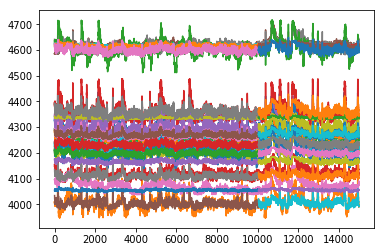

In [218]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_m_stf)+look_back, :] = trainPredict_m_stf
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_m_stf)+(look_back*2)+1:len(df)-1, :] = testPredict_m_stf
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Baseline Persistence forecast

In [186]:
def persitence_dataset(X):
    return X[:,-3,:]

### Predict

In [187]:
YtrainpredPersitence = persitence_dataset(trainX)
YtestpredPersitence = persitence_dataset(testX)


+ Invert transformation for the predictions

In [188]:
YtrainpredPersitence_inv = scaler.inverse_transform(YtrainpredPersitence)
YtrainpredPersitence_original_inv = scaler.inverse_transform(trainY)
YtestpredPersitence_inv = scaler.inverse_transform(YtestpredPersitence)
YtestpredPersitence_original_inv = scaler.inverse_transform(testY)

+ Compute mean square error

In [189]:
train_score = mean_squared_error(YtrainpredPersitence_inv.T,
                                YtrainpredPersitence_original_inv.T,
                                multioutput = 'raw_values')
train_score = np.sqrt(train_score.sum()) * 1./train_score.shape[0]
print('Train Score: %.2f RMSE' % (train_score))
test_score = mean_squared_error(YtestpredPersitence_inv.T,
                                YtestpredPersitence_original_inv.T,
                                multioutput = 'raw_values')
test_score = np.sqrt(test_score.sum()) * 1./test_score.shape[0]
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.10 RMSE
Test Score: 0.14 RMSE


### plot

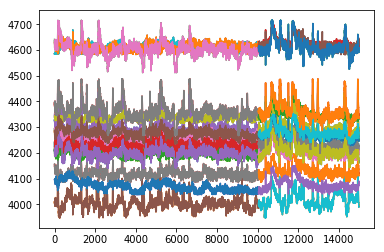

In [181]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(YtrainpredPersitence_inv)+look_back, :] = YtrainpredPersitence_inv
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(YtrainpredPersitence_inv)+(look_back*2)+1:len(df)-1, :] = YtestpredPersitence_inv
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Deferentiating the dataset

In [208]:
def difference(dataset, interval=1):
    return dataset[interval:,:] - dataset[:-interval,:]

In [232]:
def undifference(dataset, firsts, interval=1):
    undiff = firsts
    for row in dataset:
        undiff.append(row + undiff[-interval])
    return undiff

In [212]:
def create_dataset(dataset, look_back=1, dimension = range(14)):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), dimension]
        dataX.append(a)
        dataY.append(dataset[i + look_back, dimension])
    return np.array(dataX), np.array(dataY)

In [209]:
train_diff = difference(train)
test_diff = difference(test)

In [213]:
look_back = 3
dimensions = range(14)
trainX_diff, trainY_diff = create_dataset(train_diff, look_back,dimensions)
testX_diff, testY_diff = create_dataset(test_diff, look_back,dimensions)
if len(trainX.shape) < 3:
    trainX_diff = np.reshape(trainX_diff, (trainX_diff.shape[0], 1, trainX_diff.shape[1]))
    testX_diff = np.reshape(testX_diff, (testX_diff.shape[0], 1, testX_diff.shape[1]))
print trainX_diff.shape, trainY_diff.shape

(10031, 3, 14) (10031, 14)


## Multilayered LSTM 

In [220]:
model_diffe = Sequential()
model_diffe.add(LSTM(4, batch_input_shape=(batch_size, look_back, len(dimensions)), stateful=True, return_sequences=True))
model_diffe.add(LSTM(4, batch_input_shape=(batch_size, look_back, len(dimensions)), stateful=True))
model_diffe.add(Dense(len(dimensions)))
model_diffe.compile(loss='mean_squared_error', optimizer='adam')
for i in range(2):
    model_diffe.fit(trainX_diff,
                    trainY_diff,
                    epochs=1,
                    batch_size=batch_size,
                    verbose=2,
                    shuffle=False)
    model_diffe.reset_states()

Epoch 1/1
133s - loss: 0.0018
Epoch 1/1
137s - loss: 0.0017


### Predict

In [221]:
trainPredict_diffe = model_diffe.predict(trainX_diff,batch_size=batch_size)
model_m_stf.reset_states()
testPredict_diffe = model_diffe.predict(testX_diff,batch_size=batch_size)

+ Invert and undifference

In [260]:
Ytrain_original_inv = scaler.inverse_transform(np.asarray(undifference(trainY_diff,list(train[0:1,:]))))
Ytrainpred_diff_inv = scaler.inverse_transform(np.asarray(undifference(trainPredict_diffe,list(train[0:1,:]))))
Ytest_original_inv = scaler.inverse_transform(np.asarray(undifference(testY_diff,list(test[0:1,:]))))
Ytestpred_diff_inv = scaler.inverse_transform(np.asarray(undifference(testPredict_diffe,list(test[0:1,:]))))

+ Mean square error

In [285]:
train_score = mean_squared_error(scaler.inverse_transform(trainPredict_diffe).T,
                                scaler.inverse_transform(trainY_diff).T,
                                multioutput = 'raw_values')
train_score = np.sqrt(train_score.sum()) * 1./train_score.shape[0]
print('Train Score: %.2f RMSE' % (train_score))
test_score = mean_squared_error(scaler.inverse_transform(testPredict_diffe).T,
                                scaler.inverse_transform(testY_diff).T,
                                multioutput = 'raw_values')
test_score = np.sqrt(test_score.sum()) * 1./test_score.shape[0]
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.05 RMSE
Test Score: 0.08 RMSE


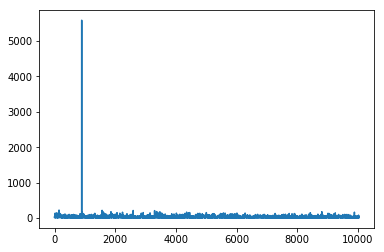

In [287]:
train_score = mean_squared_error(scaler.inverse_transform(trainPredict_diffe).T,
                                scaler.inverse_transform(trainY_diff).T,
                                multioutput = 'raw_values')
plt.plot(train_score)

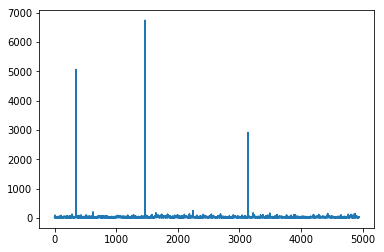

In [288]:
test_score = mean_squared_error(scaler.inverse_transform(testPredict_diffe).T,
                                scaler.inverse_transform(testY_diff).T,
                                multioutput = 'raw_values')
plt.plot(test_score)

# References
https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/